# Multi-modal and multi-vendor retina image registration
## Reimplementation by Olivier Morelle

In [2]:
def center_crop(img, size):
    center = img.shape[0] // 2, img.shape[1] // 2
    
    height_range = center[0] - size[0] // 2, center[0] + size[0] // 2
    width_range = center[1] - size[1] // 2, center[1] + size[1] // 2
    return img[height_range[0]:height_range[1],
               width_range[0]:width_range[1],
               :]
    

In [3]:
import eyepy as ep
import imageio
import matplotlib.pyplot as plt

from skimage.feature import hog, canny, plot_matches
from skimage import exposure

import numpy as np
from PIL import Image

import imageio

## Read Data, Crop and Resize

In [8]:
with ep.io.VolReader("/home/morelle/data/oct_raw/ExportRAWanonymized/67007_20190515.vol") as reader:
    nir_img = reader.read_nir()
    
cfp_img = imageio.imread("/home/morelle/data/oct_raw/ExportRAWanonymized/HS00+0EZ.003.BMP")
cfp_img = center_crop(cfp_img, (cfp_img.shape[0], cfp_img.shape[0]))


im = Image.fromarray(cfp_img)
im.thumbnail(nir_img.shape, Image.ANTIALIAS)

cfp_img = np.array(im)


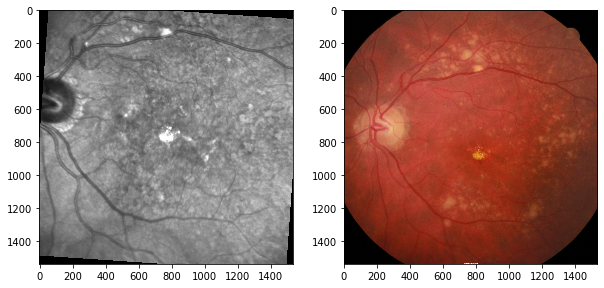

In [9]:
#imageio.imwrite("/home/morelle/Projects/octave/nir.tif", nir_img)
#imageio.imwrite("/home/morelle/Projects/octave/cfp.tif", cfp_img[..., 1])
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,20))
ax1.imshow(nir_img, cmap="gray")
ax2.imshow(cfp_img, cmap="gray")

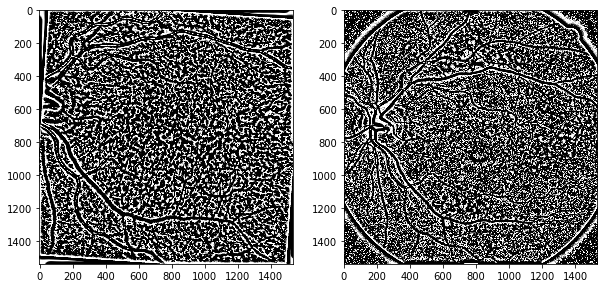

In [493]:
nir_pc = imageio.imread("/home/morelle/Projects/octave/nir_pc.tiff")
cfp_pc = imageio.imread("/home/morelle/Projects/octave/cfp_pc.tiff")

nir_pc = (nir_pc/nir_pc.max() * np.pi) -np.pi/2
cfp_pc = (cfp_pc/cfp_pc.max() * np.pi) -np.pi/2

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,20))
ax1.imshow(nir_pc, cmap="gray")
ax2.imshow(cfp_pc, cmap="gray")

## Mean phase images

In [1]:
from loggabor import mean_phase

In [21]:
min_wavelength = 9
n_scale=4
n_orient=6
sigma=0.55

nir_mp = np.log(mean_phase(nir_img, min_wavelength, sigma, n_scale, n_orient))
cfp_mp_r = np.log(mean_phase(cfp_img[..., 0], min_wavelength, sigma, n_scale, n_orient))
cfp_mp_g = np.log(mean_phase(cfp_img[..., 1], min_wavelength, sigma, n_scale, n_orient))
cfp_mp_b = np.log(mean_phase(cfp_img[..., 2], min_wavelength, sigma, n_scale, n_orient))

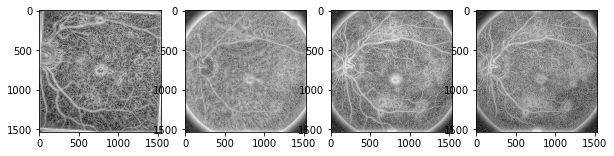

In [22]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(10,40))
ax0.imshow(nir_mp, cmap="gray")
ax1.imshow(cfp_mp_r, cmap="gray")
ax2.imshow(cfp_mp_g, cmap="gray")
ax3.imshow(cfp_mp_b, cmap="gray")

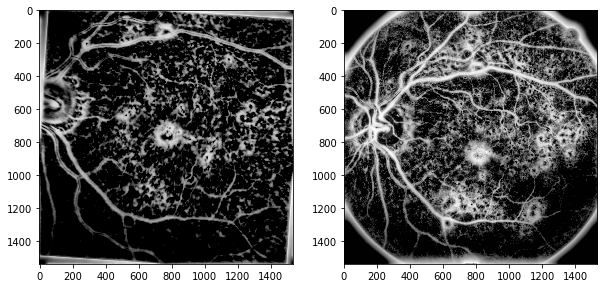

In [33]:
cfp_mp = (cfp_mp_r + cfp_mp_g + cfp_mp_b)/3

from skimage.exposure import match_histograms, equalize_adapthist

nir_mp2 = nir_mp+abs(nir_mp.min())
nir_mp2 = (nir_mp2/nir_mp2.max())*2-1

cfp_mp2 = cfp_mp+abs(cfp_mp.min())
cfp_mp2 = (cfp_mp2/cfp_mp2.max())*2-1
#cfp_pc = (cfp_pc/cfp_pc.max() * np.pi) -np.pi/2
nir_mp2 = equalize_adapthist(nir_mp2)
cfp_mp2 = equalize_adapthist(cfp_mp2)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,20))
ax1.imshow(nir_mp2, cmap="gray")
ax2.imshow(cfp_mp2, cmap="gray")

In [30]:
nir_mp.max()

3.6645212807540184

## Detect Features

In [35]:
from skimage.feature import ORB
def orb_detect_extract(img, **kwargs):
    descriptor_extractor = ORB(**kwargs)
    descriptor_extractor.detect_and_extract(img)
    keypoints = descriptor_extractor.keypoints
    descriptors = descriptor_extractor.descriptors
    
    return keypoints, descriptors

In [38]:
from skimage.feature import match_descriptors

dest_key, dest_feat = orb_detect_extract(nir_mp2, n_keypoints=500, harris_k=0.2, n_scales=30, downscale=1.1)
src_key, src_feat = orb_detect_extract(cfp_mp2, n_keypoints=500, harris_k=0.2, n_scales=30, downscale=1.1)
matches = match_descriptors(dest_feat, src_feat)

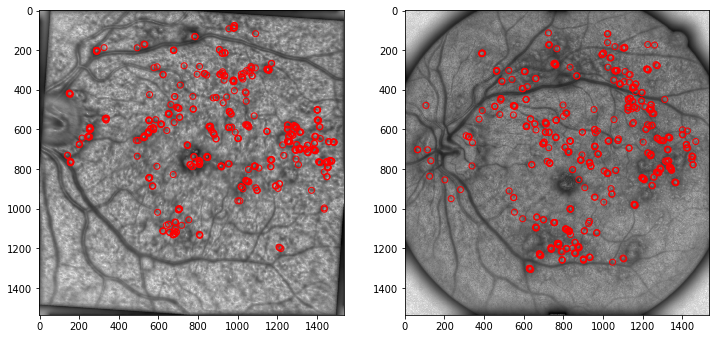

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax[0].imshow(-nir_mp, cmap=plt.cm.gray)
ax[0].scatter(dest_key[:, 1], dest_key[:, 0], facecolors='none', edgecolors='r')

ax[1].imshow(-cfp_mp, cmap=plt.cm.gray)
ax[1].scatter(src_key[:, 1], src_key[:, 0], facecolors='none', edgecolors='r')

## Apply HOG on Data

In [1456]:
M=20
N=5
orientations = 12

fd_nir, nir_hog = hog(nir_mp, orientations=orientations, pixels_per_cell=(N, N),
                    cells_per_block=(M, M), visualize=True, multichannel=False, feature_vector=False)


fd_cfp, cfp_hog = hog(cfp_mp, orientations=orientations, pixels_per_cell=(N, N),
                    cells_per_block=(M, M), visualize=True, multichannel=False, feature_vector=False)

In [1457]:
ss_nir_hog = fd_nir[::2, ::2, ...]
ss_cfp_hog = fd_cfp[::2, ::2, ...]

In [1462]:
def rotate_hog(hog_features):
    """
    
    
    """
    orientations = hog_features.shape[-1]
    M = hog_features.shape[-2]
    rotated_hog = np.zeros(hog_features.shape[:2]+(orientations, M, M, orientations))
    for block in np.ndindex(hog_features.shape[:2]):
        for rot in range(orientations):
            rotated_hog[block][rot] = np.roll(hog_features[block], rot, axis=-1)
            
    return rotated_hog

In [1463]:
ss_nir_rotated_hog = rotate_hog(ss_nir_hog)

In [1300]:
#fd_rotated_nir = np.zeros(fd_nir_5.shape[:2]+(orientations, M, M, orientations))

#for block in np.ndindex(fd_nir_5.shape[:2]):
#    for rot in range(orientations):
#        fd_rotated_nir[block][rot] = np.roll(fd_nir_5[block], rot, axis=-1)

(-0.5, 1535.5, 1535.5, -0.5)

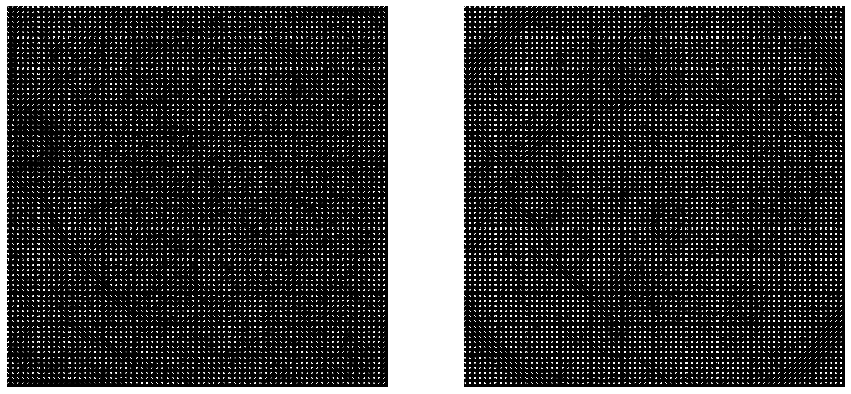

In [1464]:
nir_hog_image = exposure.rescale_intensity(nir_hog, in_range=(0, 0.05))
cfp_hog_image = exposure.rescale_intensity(cfp_hog, in_range=(0, 0.05))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))

s = np.s_[...]
ax1.imshow(nir_hog_image[s], cmap="gray")
ax2.imshow(cfp_hog_image[s], cmap="gray")

ax1.axis("off")
ax2.axis("off")

## Match approximate nearest neighbours in hog

Here I used a nearest neighbour approach from sklearn. I could also try to use the annoy package.

In [1217]:
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex

In [1439]:
def ann(src, dest, n_trees=10, metric="euc"):
    """ Searches ANN for src in dest
    
    For every feature in src the index and distanc of the ann in dest is returned 
    
    Assumes that features are on the last axis
    
    metric can be "angular", "euclidean", "manhattan", "hamming", or "dot"
    """
    orig_src_shape = src.shape[:-1]
    orig_dest_shape = dest.shape[:-1]
    
    # Compress index axis into one axis
    src = src.reshape((np.prod(orig_src_shape), -1))
    dest = dest.reshape((np.prod(orig_dest_shape), -1))
    
    t = AnnoyIndex(dest.shape[-1], 'euclidean')
    for i in range(dest.shape[0]):
        t.add_item(i, dest[i])

    t.build(n_trees)
    
    
    dest_indices = np.empty(src.shape[0], dtype=np.int)
    dest_dist = np.empty(src.shape[0], dtype=np.int)
    for i in range(src.shape[0]):
        ind, dist = t.get_nns_by_vector(src[i], n=1, search_k=-1, 
                                        include_distances=True)
        
        dest_indices[i], dest_dist[i] = ind[0], dist[0]
    
    # Change 1D dest indices to indices of the dest input array
    dest_indices = np.array([[y for y in x] for x in 
                             zip(*np.unravel_index(dest_indices, orig_dest_shape, order='C'))])

    
    # Reshape indices and distances to the input src shape
    dest_dist = dest_dist.reshape(orig_src_shape)
    dest_indices = dest_indices.reshape(orig_src_shape + dest_indices.shape[1:])
    
    return dest_indices, dest_dist

def mutual_ann_match(src_features, dest_features):
    """
    >>> ann1 = np.array([[1,2,3,4],[4,3,2,1],\
                          [1,1,2,2], [3,5,3,4],]).reshape(2,2,4)
                          
    >>> ann2 = np.array([[4,3,2,1], [1,2,3,4],\
                         [1,1,2,3], [1,1,2,4],]).reshape(2,2,4)
                     
    >>> mutual_ann_match(ann1, ann2)
    (array([[[0, 0],
            [0, 1]],
    <BLANKLINE>
           [[0, 1],
            [0, 0]],
    <BLANKLINE>
           [[1, 0],
            [1, 0]]]), array([0, 0, 1]))
    """
    # Compute indices and distances in both directions
    dest_index, dest_dist = ann(src_features, dest_features)
    src_index, src_dist = ann(dest_features, src_features)

    results = []
    
    for i in np.ndindex(dest_index.shape[:-1]):
        # i is the position in the src_index
        # nn_srcdest is the index of the nearest neighbour in dest 
        position_nn_in_src = tuple(dest_index[i])
        nn_in_src = tuple(src_index[position_nn_in_src])
        if i == nn_in_src:
            results.append([dest_dist[i], [i, position_nn_in_src]])
            #matches[i, position_nn_in_src] = dest_dist[i]
    
    results = sorted(results, key= lambda x: x[0])
    matches = np.asarray([x[1] for x in results])
    distances = np.array([x[0] for x in results])
    return matches, distances

import doctest
doctest.testmod()

TestResults(failed=0, attempted=3)

In [1390]:
49*49*12

28812

In [1250]:
matches, distances = mutual_ann_match(src_feat,
                                      dest_feat)

In [1465]:
new_shape_rotated_nir = (ss_nir_rotated_hog.shape[:3]) + (np.prod(ss_nir_rotated_hog.shape[3:]),)
new_shape_cfp = (ss_cfp_hog.shape[:2]) + (np.prod(ss_cfp_hog.shape[2:]),)
matches, distances = mutual_ann_match(ss_cfp_hog.reshape(new_shape_cfp),
                                      ss_nir_rotated_hog.reshape(new_shape_rotated_nir))

In [1466]:
len_m = matches.shape[0]
mapping = np.tile(np.arange(len_m).reshape(len_m,1), 2)

In [1470]:
keypoints1 = (np.array(matches[:, 0].tolist())*N+(N*M/2))*2
keypoints2 = (np.array(matches[:, 1].tolist())*N+(N*M/2))*2

In [722]:
#new_shape_nir = (fd_nir_5.shape[:2]) + (np.prod(fd_nir_5.shape[2:]),)
#new_shape_cfp = (fd_cfp_5.shape[:2]) + (np.prod(fd_cfp_5.shape[2:]),)
#matches, distances = mutual_ann_match(fd_cfp_5.reshape(new_shape_cfp)*1000,
#                                      fd_nir_5.reshape(new_shape_nir)*1000)

#matches = (matches*N+(N*M/2))*5

IndexError: boolean index did not match indexed array along dimension 0; dimension is 177 but corresponding boolean dimension is 67

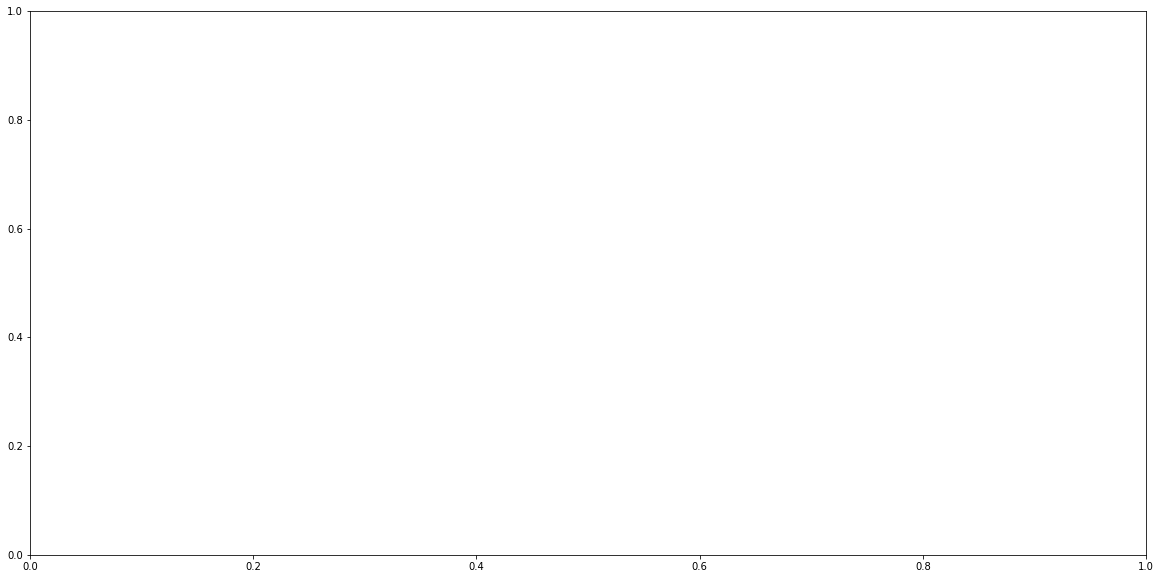

In [1521]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
plot_matches(ax, nir_img, cfp_img[..., 1], keypoints1, keypoints2[:, :2], mapping[inliers], only_matches=True)

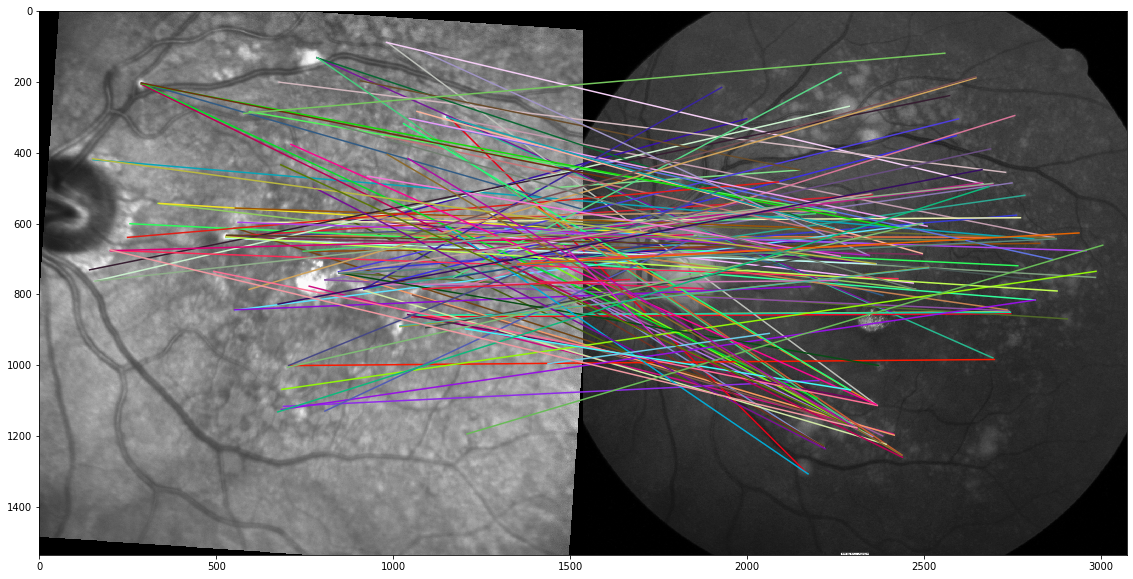

In [40]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
plot_matches(ax, nir_img, cfp_img[..., 1], dest_key, src_key, matches, only_matches=True)

## Use RANSAC for robust estimation of affine transformation

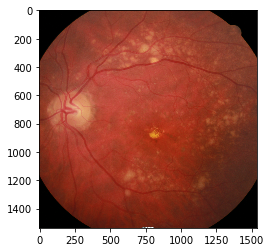

In [43]:
import numpy as np
from matplotlib import pyplot as plt

from skimage import data
from skimage.util import img_as_float
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches)
from skimage.transform import warp, AffineTransform
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray, gray2rgb
from skimage.measure import ransac

model_robust, inliers = ransac((src_key[matches[:,1]],dest_key[matches[:,0]]), AffineTransform, min_samples=3,
                               residual_threshold=2, max_trials=1000)
outliers = inliers == False

transformed_cfp = warp(cfp_img, model_robust.inverse, )#output_shape=nir_img.shape)
plt.imshow((gray2rgb(transformed_cfp*255).astype(int)))

In [44]:
inliers.sum()

132

In [210]:
from skimage.feature import ORB
from skimage.feature import match_descriptors

def orb_detect_extract(img, **kwargs):
    descriptor_extractor = ORB(**kwargs)
    descriptor_extractor.detect_and_extract(img)
    keypoints = descriptor_extractor.keypoints
    descriptors = descriptor_extractor.descriptors
    
    return keypoints, descriptors


def multimodal_registration(src_img, dest_img, mp_kwargs={}):
    
    # Calculate Mean Phase Image
    src_mp = np.log(mean_phase(src_img, min_wavelength, sigma, n_scale, n_orient))
    dest_mp = np.log(mean_phase(dest_img, min_wavelength, sigma, n_scale, n_orient))
    
    # Detect Features
    dest_key, dest_feat = orb_detect_extract(dest_mp, n_keypoints=200)
    src_key, src_feat = orb_detect_extract(src_mp, n_keypoints=200)

    # Match Features
    matches = match_descriptors(dest_feat, src_feat, cross_check=True)
    fig, ax1 = plt.subplots(1,1,)# figsize=(10,20))
    plot_matches(ax1, dest_img, src_img, dest_key, src_key, matches)
    plt.show()
    
    # Compute Affine
    dest_key = dest_key[:,[1,0]]
    src_key = src_key[:,[1,0]]
    
    model_robust, inliers = ransac((dest_key[matches[:,0]],src_key[matches[:,1]]), AffineTransform, min_samples=3,
                               residual_threshold=0.3, max_trials=1000)
    
    model_robust = AffineTransform()
    model_robust.estimate(dest_key[matches[:,0][inliers]],src_key[matches[:,1][inliers]])
    
    fig, ax1 = plt.subplots(1,1,)# figsize=(10,20))
    plot_matches(ax1, dest_img, src_img, dest_key, src_key, matches[inliers])
    plt.show()


    # Warp Image
    transformed_src = warp(src_img, model_robust.inverse)
    
    return transformed_src, model_robust, dest_key[matches[:,0]][inliers], src_key[matches[:,1]][inliers]

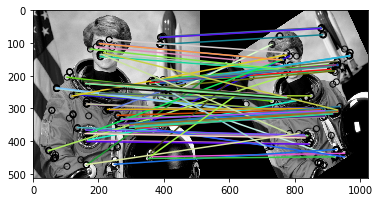

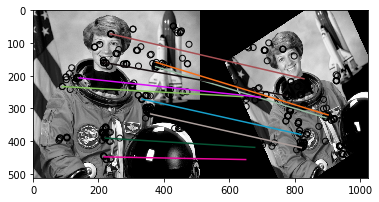

In [213]:
from skimage import data
from skimage.transform import rotate

img1 = rgb2gray(data.astronaut())
tform = AffineTransform(scale=(1.3, 1.1), rotation=0.5,
                           translation=(0, -200))
img2 = warp(img1, tform)

reg_img2, affine, dest_key, src_key = multimodal_registration(img2, img1)

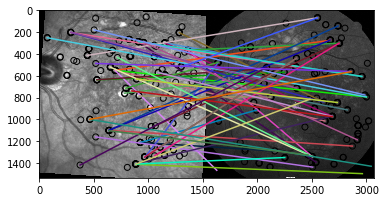

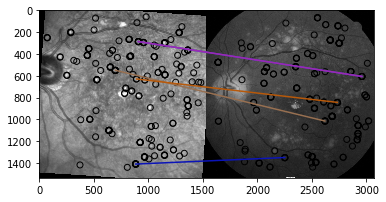

In [189]:
reg_img2, affine = multimodal_registration(cfp_img[..., 1], nir_img)

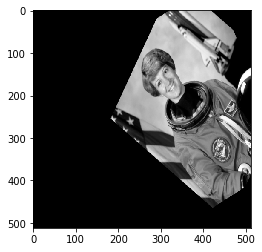

In [214]:
plt.imshow(reg_img2, cmap="gray")

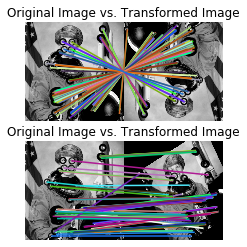

In [64]:


from skimage import data
from skimage import transform as tf
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt


img1 = rgb2gray(data.astronaut())
img2 = tf.rotate(img1, 180)
tform = tf.AffineTransform(scale=(1.3, 1.1), rotation=0.5,
                           translation=(0, -200))
img3 = tf.warp(img1, tform)

descriptor_extractor = ORB(n_keypoints=200)

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img3)
keypoints3 = descriptor_extractor.keypoints
descriptors3 = descriptor_extractor.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
matches13 = match_descriptors(descriptors1, descriptors3, cross_check=True)

fig, ax = plt.subplots(nrows=2, ncols=1)

plt.gray()

plot_matches(ax[0], img1, img2, keypoints1, keypoints2, matches12)
ax[0].axis('off')
ax[0].set_title("Original Image vs. Transformed Image")

plot_matches(ax[1], img1, img3, keypoints1, keypoints3, matches13)
ax[1].axis('off')
ax[1].set_title("Original Image vs. Transformed Image")


plt.show()


In [134]:
af = tf.AffineTransform()
af.estimate(keypoints3, keypoints1)
af

<AffineTransform(matrix=
    [[ -8.99196937,   8.46453439, 309.30351282],
     [-56.90782559,  51.7832208 , 505.40932594],
     [  0.        ,   0.        ,   1.        ]]) at 0x7fd0a7006cc0>

In [135]:
tform

<AffineTransform(matrix=
    [[   1.14085733,   -0.52736809,    0.        ],
     [   0.6232532 ,    0.96534082, -200.        ],
     [   0.        ,    0.        ,    1.        ]]) at 0x7fd0a764d7f0>

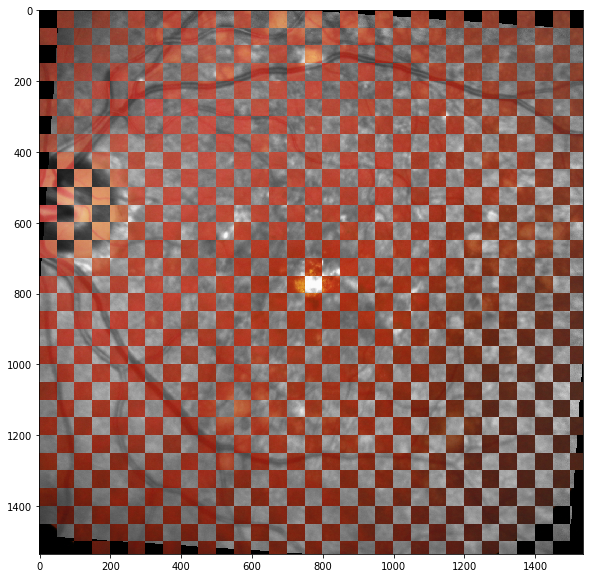

In [477]:
plot_registration_comparison(nir_img, transformed_cfp, square_size=50)

# Example code

Ground truth:
Scale: (0.9000, 0.9000), Translation: (-10.0000, 20.0000), Rotation: -0.2000
Affine transform:
Scale: (0.9015, 0.8913), Translation: (-9.3136, 14.9768), Rotation: -0.1678
RANSAC:
Scale: (0.8999, 0.9001), Translation: (-10.0005, 19.9744), Rotation: -0.1999


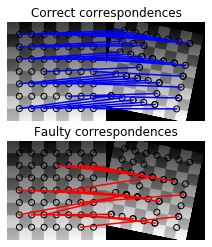

In [169]:
import numpy as np
from matplotlib import pyplot as plt

from skimage import data
from skimage.util import img_as_float
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches)
from skimage.transform import warp, AffineTransform
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
from skimage.measure import ransac


# generate synthetic checkerboard image and add gradient for the later matching
checkerboard = img_as_float(data.checkerboard())
img_orig = np.zeros(list(checkerboard.shape) + [3])
img_orig[..., 0] = checkerboard
gradient_r, gradient_c = (np.mgrid[0:img_orig.shape[0],
                                   0:img_orig.shape[1]]
                          / float(img_orig.shape[0]))
img_orig[..., 1] = gradient_r
img_orig[..., 2] = gradient_c
img_orig = rescale_intensity(img_orig)
img_orig_gray = rgb2gray(img_orig)

# warp synthetic image
tform = AffineTransform(scale=(0.9, 0.9), rotation=0.2, translation=(20, -10))
img_warped = warp(img_orig, tform.inverse, output_shape=(200, 200))
img_warped_gray = rgb2gray(img_warped)

# extract corners using Harris' corner measure
coords_orig = corner_peaks(corner_harris(img_orig_gray), threshold_rel=0.001,
                           min_distance=5)
coords_warped = corner_peaks(corner_harris(img_warped_gray),
                             threshold_rel=0.001, min_distance=5)

# determine sub-pixel corner position
coords_orig_subpix = corner_subpix(img_orig_gray, coords_orig, window_size=9)
coords_warped_subpix = corner_subpix(img_warped_gray, coords_warped,
                                     window_size=9)


def gaussian_weights(window_ext, sigma=1):
    y, x = np.mgrid[-window_ext:window_ext+1, -window_ext:window_ext+1]
    g = np.zeros(y.shape, dtype=np.double)
    g[:] = np.exp(-0.5 * (x**2 / sigma**2 + y**2 / sigma**2))
    g /= 2 * np.pi * sigma * sigma
    return g


def match_corner(coord, window_ext=5):
    r, c = np.round(coord).astype(np.intp)
    window_orig = img_orig[r-window_ext:r+window_ext+1,
                           c-window_ext:c+window_ext+1, :]

    # weight pixels depending on distance to center pixel
    weights = gaussian_weights(window_ext, 3)
    weights = np.dstack((weights, weights, weights))

    # compute sum of squared differences to all corners in warped image
    SSDs = []
    for cr, cc in coords_warped:
        window_warped = img_warped[cr-window_ext:cr+window_ext+1,
                                   cc-window_ext:cc+window_ext+1, :]
        SSD = np.sum(weights * (window_orig - window_warped)**2)
        SSDs.append(SSD)

    # use corner with minimum SSD as correspondence
    min_idx = np.argmin(SSDs)
    return coords_warped_subpix[min_idx]


# find correspondences using simple weighted sum of squared differences
src = []
dst = []
for coord in coords_orig_subpix:
    src.append(coord)
    dst.append(match_corner(coord))
src = np.array(src)
dst = np.array(dst)


# estimate affine transform model using all coordinates
model = AffineTransform()
model.estimate(src, dst)

# robustly estimate affine transform model with RANSAC
model_robust, inliers = ransac((src, dst), AffineTransform, min_samples=3,
                               residual_threshold=2, max_trials=100)
outliers = inliers == False


# compare "true" and estimated transform parameters
print("Ground truth:")
print(f"Scale: ({tform.scale[1]:.4f}, {tform.scale[0]:.4f}), "
      f"Translation: ({tform.translation[1]:.4f}, "
      f"{tform.translation[0]:.4f}), "
      f"Rotation: {-tform.rotation:.4f}")
print("Affine transform:")
print(f"Scale: ({model.scale[0]:.4f}, {model.scale[1]:.4f}), "
      f"Translation: ({model.translation[0]:.4f}, "
      f"{model.translation[1]:.4f}), "
      f"Rotation: {model.rotation:.4f}")
print("RANSAC:")
print(f"Scale: ({model_robust.scale[0]:.4f}, {model_robust.scale[1]:.4f}), "
      f"Translation: ({model_robust.translation[0]:.4f}, "
      f"{model_robust.translation[1]:.4f}), "
      f"Rotation: {model_robust.rotation:.4f}")

# visualize correspondence
fig, ax = plt.subplots(nrows=2, ncols=1)

plt.gray()

inlier_idxs = np.nonzero(inliers)[0]
plot_matches(ax[0], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((inlier_idxs, inlier_idxs)), matches_color='b')
ax[0].axis('off')
ax[0].set_title('Correct correspondences')

outlier_idxs = np.nonzero(outliers)[0]
plot_matches(ax[1], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((outlier_idxs, outlier_idxs)), matches_color='r')
ax[1].axis('off')
ax[1].set_title('Faulty correspondences')

plt.show()

In [172]:
x

array([], dtype=float64)

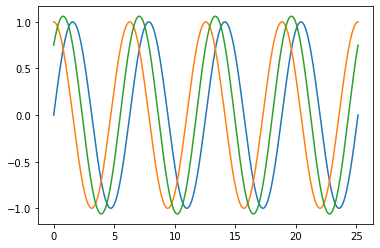

In [181]:
x = np.linspace(0,8*np.pi, 1000)
sin = np.sin(x) #+ np.cos(x)
cos = np.cos(x)
sc = 0.75*sin + .75*cos
plt.plot(x, sin)
plt.plot(x, cos)
plt.plot(x, sc)